In [1]:
import os
import torch
import torchvision
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

# Enable inline plotting
%matplotlib inline


In [2]:
# Download latest version of dataset
data_dir = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", data_dir)

# Get class names
classes = os.listdir(data_dir)
print(classes)


Path to dataset files: /root/.cache/kagglehub/datasets/asdasdasasdas/garbage-classification/versions/2
['one-indexed-files.txt', 'garbage classification', 'one-indexed-files-notrash_train.txt', 'one-indexed-files-notrash_val.txt', 'Garbage classification', 'zero-indexed-files.txt', 'one-indexed-files-notrash_test.txt']


In [3]:
# Define transformations
transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load dataset with transformations
dataset = ImageFolder(data_dir, transform=transformations)


Label: Garbage classification (Class No: 0)


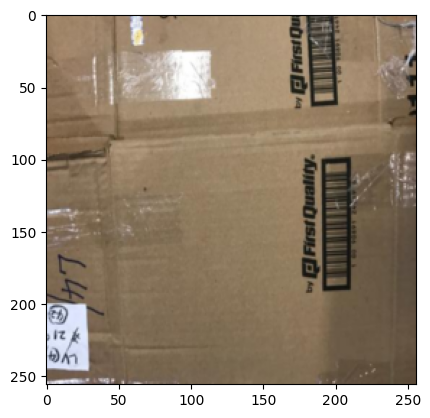

In [4]:
# Function to display sample images
def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

# Display a sample image
img, label = dataset[10]
show_sample(img, label)


In [6]:
# Get dataset length
dataset_size = len(dataset)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

# Compute actual split sizes
train_size = int(train_ratio * dataset_size)
val_size = int(val_ratio * dataset_size)
test_size = dataset_size - train_size - val_size  # Ensure sum matches dataset length

# Set random seed for reproducibility
torch.manual_seed(42)

# Perform the split
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

print(f"Train size: {len(train_ds)}, Val size: {len(val_ds)}, Test size: {len(test_ds)}")


Train size: 3537, Val size: 505, Test size: 1012


In [7]:
# Define batch size
batch_size = 32

# Create data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers=4, pin_memory=True)



/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


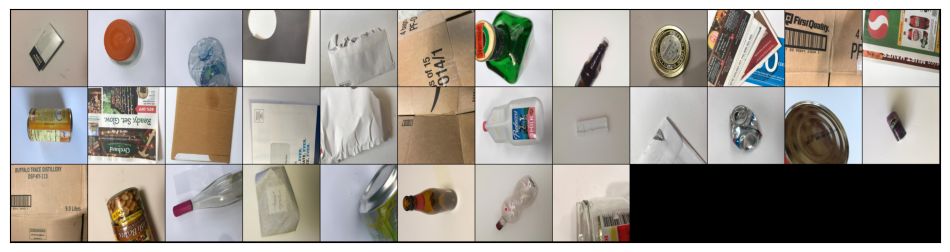

In [8]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=12).permute(1, 2, 0))
        break

# Show a batch of images
show_batch(train_dl)


In [9]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)  # Generate predictions
        loss = F.cross_entropy(out, labels)  # Calculate loss
        acc = accuracy(out, labels)  # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print(f"Epoch [{epoch+1}]: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")


In [10]:
class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class ResNet(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)  # Use weights instead of pretrained
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, len(dataset.classes))  # Adjust output layer for your classes

    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

model = ResNet()


In [ ]:
import torch

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)

    for epoch in range(epochs):
        model.train()
        train_losses = []

        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Debugging: Check model type and device
        print(type(model))  # Expected: <class 'torchvision.models.resnet.ResNet'>
        print(next(model.parameters()).device)  # Should match your training device (CPU or GPU)

        # Ensure model is in evaluation mode before validation
        model.eval()
        with torch.no_grad():
            result = evaluate(model, val_loader)

        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)

    return history

# Training Configuration
num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5

# Ensure `model`, `train_dl`, and `val_dl` are properly defined before calling `fit`
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


In [1]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

num_epochs = 10
opt_func = torch.optim.Adam
lr = 5.5e-5
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)


NameError: name 'torch' is not defined

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    prob, preds = torch.max(yb, dim=1)
    return dataset.classes[preds[0].item()]

img, label = test_ds[17]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))
